# Mass Transports

Transport diagnostics for flow through major straits.

## Theory

Formally, mass transports are given by
$$T_x = \rho u  $$
$$T_y = \rho v  $$

Mass transports are diagnostics that are calculated online by the model:

|variable|long name|units|dimensions|
|-|
|tx_trans|T-cell i-mass transport|Sv|(time,st_ocean,xu_ocean,yt_ocean)|
|ty_trans|T-cell j-mass transport|Sv|(time,st_ocean,xt_ocean,yu_ocean)|


These variables are saved in `ocean.nc` files.

## Calculation

In [1]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
from dask.distributed import Client

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
#cc.start_cluster()
client = Client('tcp://10.0.64.12:8786')
client

Client Scheduler: tcp://10.0.64.12:8786 Dashboard: http://10.0.64.12:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


In [4]:
# Strait locations: [minlon, maxlon, minlat, maxlat]
# Add as many as you like, but they must be zonal or meridional

straits_01deg = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
            ('Lombok Strait', [-244.3, -243.8, -8.37, -8.37]),
            ('Ombai Strait',  [-234.9, -234.9, -8.86, -8.27]),
            ('Timor Strait',  [-232.6, -232.6, -13.96, -8.37]),
            ('Bering Strait', [-172, -167, 65.8, 65.8]),
            ('Denmark Strait',[-42, -22, 65.8, 65.8])
            ])
straits_025deg = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
            ('Lombok Strait', [-244.5, -243.5, -8.22, -8.22]),
            ('Ombai Strait',  [-235.5, -235.5, -9.21, -8.47]),
            ('Timor Strait',  [-233, -233, -13.86, -8.71])
            ])
straits_1deg = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('Drake Passage', [-69.9, -69.9, -71.6, -51.0]),
            ('Lombok Strait', [-245, -242, -8.33, -8.33]),
            ('Ombai Strait',  [-237, -237, -10.33, -8.33]),
            ('Timor Strait',  [-233, -233, -13.9, -9])
            ])

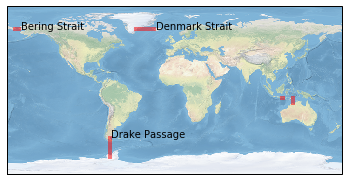

In [6]:
# TODO: plot straits on actual model bathymetry 


import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for strait, (xmin, xmax, ymin, ymax) in straits_01deg.items():

    plt.plot([xmin, xmax], [ymin, ymax],
            color='red', linewidth=4, alpha=0.5,
             transform=ccrs.Geodetic() )
   
    plt.annotate(xy=(xmin, ymin), xycoords='data',
                 xytext=(xmax+2, ymax),
                 s=strait,
               #  arrowprops=dict(facecolor='black', shrink=0.05),
                 transform=ccrs.Geodetic(),
                clip_on=True)

#ax.set_global()
#plt.annotate(xy=(0, 0), s='origin', transform=ccrs.Geodetic())
#plt.show()


In [5]:
##@memory.cache
def calc_transport(ekey, strait):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
     
    Designed for flow through straits.
    """
    
    expt = exptdata.exptdict[ekey]['expt']
    n = None #exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    print('Calculating {} {} transport'.format(expt, strait))
    print('with {} files, time units of {} and offset of  {} days'.format(n, time_units, offset))
    
    if ekey=='1deg':
        straits=straits_1deg
    if ekey=='025deg':
        straits=straits_025deg
    if ekey=='01deg':
        straits=straits_01deg
    
    xmin, xmax, ymin, ymax = straits[strait]
    
    if xmin == xmax:
        tx_trans = cc.get_nc_variable(expt, 
                                'ocean_month.nc', 
                                'tx_trans_int_z',
                                 n=n,
                                 time_units=time_units, offset=offset)
        
        transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))\
                            .sum('yt_ocean')

    elif ymin == ymax:
        ty_trans = cc.get_nc_variable(expt, 
                                      'ocean_month.nc', 
                                      'ty_trans_int_z',
                                      n=n,
                                      time_units=time_units, offset=offset)
        transport = ty_trans.sel(yu_ocean=ymin, method='nearest')\
                            .sel(xt_ocean=slice(xmin, xmax))\
                            .sum('xt_ocean')
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.compute()
       
    return transport

### A plot for Indonesian Seas only

In [7]:
%%time
itf_straits = ['Lombok Strait', 'Ombai Strait',  'Timor Strait']
results = []
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    for i, strait in enumerate(itf_straits):
# convert from kg/s to Sv, assuming typical in-situ density of 1036kg/m^3
# https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293
        transport = calc_transport(ekey, strait)/1e6/1036
        transport_mean = transport.resample(time='A').mean('time')
        
        result = {'transport_mean': transport_mean,'expt': expt,'desc': desc,'i': i}
        results.append(result)

IPython.display.clear_output()

CPU times: user 3min 3s, sys: 1min 18s, total: 4min 22s
Wall time: 5min 13s


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous a

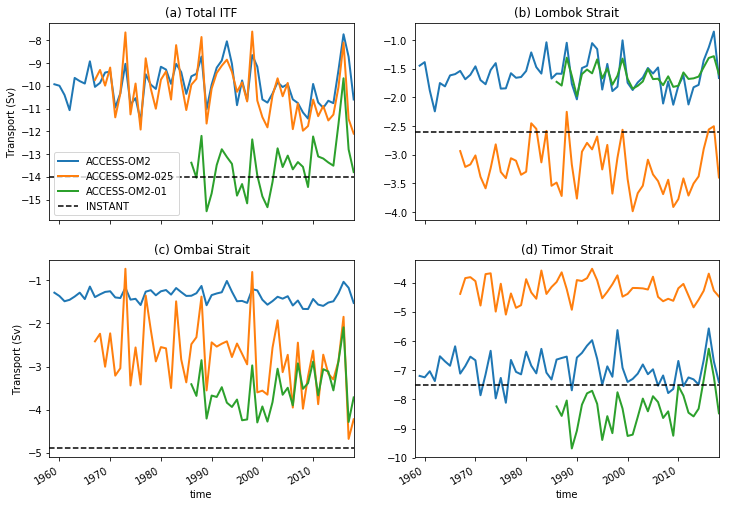

In [8]:
plt.figure(figsize=(12,8))
for result in results:
    transport_mean = result['transport_mean']
    desc = result['desc']
    i = result['i']
    
    if i==0:
        total_transport = transport_mean
    else:
        total_transport = total_transport+transport_mean
        
    plt.subplot(2, 2, i+2)
    transport_mean.plot(label=desc, linewidth=2)
    plt.ylabel('')
    plt.gca().autoscale()

    if i ==2:
        plt.subplot(221)
        total_transport.plot(label=desc, linewidth=2)
        plt.title('(a) Total ITF')
        plt.ylabel('')
        plt.gca().autoscale()

for k in range(1,i+2,2):
    plt.subplot(2, 2, k)
    plt.ylabel('Transport (Sv)')

for k in range(1,3,1):
    plt.subplot(2, 2, k)
    plt.xlabel('')
    plt.gca().axes.xaxis.set_ticklabels([])

plt.subplot(221)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-14, -14],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.legend()

plt.subplot(222)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-2.6, -2.6],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(b) '+itf_straits[0])

plt.subplot(223)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-4.9, -4.9],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(c) '+itf_straits[1])

plt.subplot(224)
plt.plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[-7.5, -7.5],'k--',label="INSTANT")
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
plt.title('(d) '+itf_straits[2])

savefigure('ITF_transport')

# Drake Passage Transport

In [7]:
%%time
strait = 'Drake Passage'
results = []
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    transport = calc_transport(ekey, strait)/1e6/1036
    transport_mean = transport.resample(time='A').mean('time')
    result = {'transport_mean': transport_mean,'expt': expt,'desc': desc}
    results.append(result)

IPython.display.clear_output()
    

CPU times: user 57.6 s, sys: 27.8 s, total: 1min 25s
Wall time: 2min 49s


In [8]:
def add_cycles(ax):
    cycle_dates = [1718, 1778, 1838, 1898, 1958, 2018]
    ylims=ax.get_ylim()
    for cd in cycle_dates:
        ax.plot([pd.datetime(cd,1,1),pd.datetime(cd,1,1)],ylims,'k--',linewidth=0.8)
    ax.set_ylim(ylims)

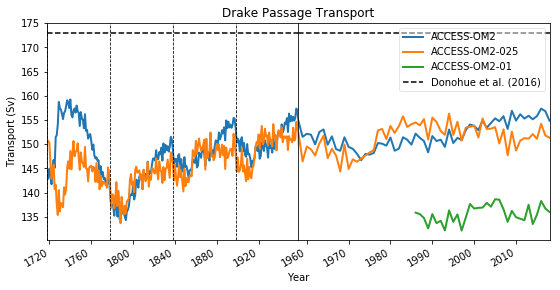

In [11]:
fig,ax = plt.subplots(1,2,figsize=(9,4))
fig.subplots_adjust(wspace=0.0)
for result in results:
    transport_mean = result['transport_mean']
    desc = result['desc']
    transport_mean.plot(ax = ax[0],label=desc, linewidth=2)
    transport_mean.plot(ax = ax[1],label=desc, linewidth=2)

    
ax[0].plot([pd.datetime(1718,1,1),pd.datetime(1957,12,31)],[173, 173],'k--',label="Donohue et al. (2016)")
ax[1].plot([pd.datetime(1958,1,1),pd.datetime(2017,12,31)],[173, 173],'k--',label="Donohue et al. (2016)")
l2=ax[1].legend(fancybox=True, framealpha=0.5)
ax[0].set_xlim([pd.datetime(1718,1,1),pd.datetime(1957,12,31)])
ax[1].set_xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
ax[0].set_title('')
t2 = ax[1].set_title('Drake Passage Transport')
t2.set_position((0.0,1.0))
ax[0].set_xlabel('')
x2 = ax[1].set_xlabel('Year')
x2.set_position((0.0, 17.2))
ax[0].set_ylabel('Transport (Sv)')
ax[1].set_yticks([])
ax[1].set_ylabel('')

add_cycles(ax[0])

savefigure('DP_transport')

**Below here, not used for manuscript**
----

In [ ]:
ncols = 2
nrows = math.ceil(len(straits)/ncols)
tstart = 1e10
tend = -1e10
# transports = copy.deepcopy(exptdata.exptdict)  # this will store speed fields under the same keys as exptdata.exptdict
plt.figure(figsize=(12,10))
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    desc = exptdata.exptdict[ekey]['desc']
    for i, strait in enumerate(straits):
# convert from kg/s to Sv, assuming typical in-situ density of 1036kg/m^3
# https://www.nature.com/scitable/knowledge/library/key-physical-variables-in-the-ocean-temperature-102805293
#        if ekey == '01deg':
#            transport = calc_transport(expt, strait,n=410)/1e6/1036
#             tstart = min(tstart, transport['time'].data[0])  # first time in model data
#             tend = max(tend, transport['time'].data[-1])  # final time in model data
#        else:
        transport = calc_transport(ekey, strait)/1e6/1036
        transport_mean = transport.resample(time='A').mean('time')
        plt.subplot(nrows, ncols, i+1)
        transport_mean.plot(label=desc+', annual mean', linewidth=2)
        #transport.plot(label=desc, linewidth=0.2, alpha=0.5)
        plt.title(strait)
        plt.ylabel('')
        plt.gca().autoscale()

for k in range(1,i+2,2):
    plt.subplot(nrows, ncols, k)
    plt.ylabel('Transport (Sv)')

for k in range(1,i,1):
    plt.subplot(nrows, ncols, k)
    plt.xlabel('')
    plt.gca().axes.xaxis.set_ticklabels([])

# for k in range(1,i+2,1):
#     plt.subplot(nrows, ncols, k)
#     plt.gca().xlim([tstart, tend])

plt.subplot(nrows, ncols, i+1)
plt.legend(bbox_to_anchor=(-0.1,-0.25), loc='upper center')

savefigure('strait_transports')

In [12]:
ekey = '025deg'
expt = exptdata.exptdict[ekey]['expt']
n = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
n=30
offset=0
tx_trans = cc.get_nc_variable(expt, 
                                'ocean_month.nc', 
                                'tx_trans_int_z',
                                 n=n,
                                 time_units=time_units, offset=offset)
        

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


ERROR:sqlalchemy.pool.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 459, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140512886740736 and this is thread id 140511030036224.
ERROR:sqlalchemy.pool.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7fcb3461c570>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs

-3059819000.0


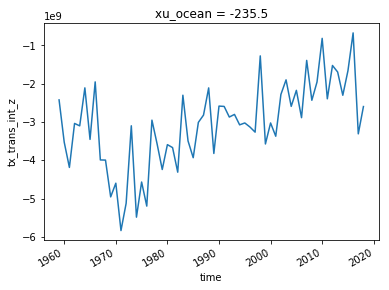

In [13]:
xmin, xmax, ymin, ymax = straits_025deg['Ombai Strait']

transport = tx_trans.sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax))

transport.sum('yt_ocean').resample(time='A').mean('time').plot()
print(transport.mean('time').sum('yt_ocean').values)


In [11]:
temp = transport.sum('yt_ocean').resample(time='A').mean('time')



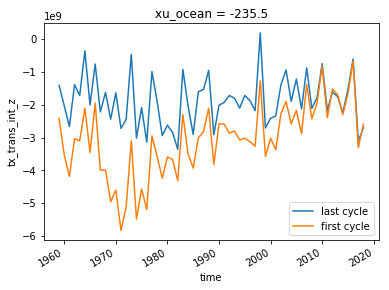

In [14]:
temp.plot(label='last cycle')
transport.sum('yt_ocean').resample(time='A').mean('time').plot(label='first cycle')
plt.legend()

In [6]:
n

-30